# Project 1, Part 4, Holiday Analytics

University of California, Berkeley
Master of Information and Data Science (MIDS) program
w205 - Fundamentals of Data Engineering

Student: John (Jack) Galvin

Year: 2022

Semester: Spring

Section: 9


# Included Modules and Packages

Code cell containing your includes for modules and packages

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

import psycopg2

# Supporting code

Code cells containing any supporting code, such as connecting to the database, any functions, etc.  Remember you can use any code from the labs.

In [3]:
# Function to run a select query and return rows in a pandas dataframe
# Pandas puts all numeric values from postgres to float
# If it will fit in an integer, change it to integer


def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

In [4]:
# Connect to Postgres

connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

In [5]:
# Create a cursor for the connection

cursor = connection.cursor()

## How do holidays affect the sales, considering both the actual holiday, and the days before and after the holiday? 

## Create an executive summary explaining how holidays have affected sales. 

## You must support your summary with data, in the form of output of queries, data visualization, etc. There is a 1 query minimum.

# Assumptions

* Holidays under examination for analysis are all of the ones listed in the holidays table
* "Sales" will be analyzed with respect to daily revenue across all stores and daily quantity of meals sold across all stores
* The Executive Summary that would be presented / sent to the executives is at the bottom of this notebook. The code cells and sections are demarcated so that you can follow my work

## Query 1 - Transaction Level Detail, USD

In [6]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select sale_date as date,
        total_amount as usd
from sales
order by sale_date

"""

df1 = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df1

,date,usd
0,2020-01-01,96
1,2020-01-01,144
2,2020-01-01,48
3,2020-01-01,24
4,2020-01-01,108
...,...,...
1537612,2020-12-31,60
1537613,2020-12-31,96
1537614,2020-12-31,60
1537615,2020-12-31,12


## Query 2 - Total Meals Sold, by Day

In [ ]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select sa.sale_date as date,
        sum(l.quantity) as meals_sold
from sales as sa
    join line_items as l
        on sa.store_id = l.store_id and sa.sale_id = l.sale_id
group by date
order by date

"""

df2 = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df2

## Query 3 - Holidays

In [ ]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select *
from holidays

"""

df3 = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df3

# Merge Data Frames

In [ ]:
# Roll df1 up to daily and set the index as date

df1["date"] = pd.to_datetime(df1["date"])
df1 = pd.DataFrame(df1.groupby("date")["usd"].sum())
df1

In [ ]:
# Set the index as date in df2 and df3

df2["date"] = pd.to_datetime(df2["date"])
df3["holiday_date"] = pd.to_datetime(df3["holiday_date"])

df2.set_index("date", inplace=True)
df3.set_index("holiday_date", inplace=True)

In [ ]:
# Merge df1 and df2

df = df1.join(df2)

In [ ]:
# Merge df3

df = df.join(df3, how="outer")

# Data Manipulation and Feature Extraction

In [ ]:
# Fill NaN for usd and meals_sold (Thanksgiving and Christmas)

df["usd"].fillna(0, inplace=True)
df["meals_sold"].fillna(0, inplace=True)

In [ ]:
# Create a new column as a holiday indicator

df["is_holiday"] = np.where(df["description"].isna() == True, 0, 1)

In [ ]:
# Create several columns for rolling sums of usd (previous n days)
df["past_2_usd"] = df["usd"].rolling(window = 2).apply(sum)
df["past_3_usd"] = df["usd"].rolling(window = 3).apply(sum)
df["past_4_usd"] = df["usd"].rolling(window = 4).apply(sum)
df["past_5_usd"] = df["usd"].rolling(window = 5).apply(sum)
df["past_6_usd"] = df["usd"].rolling(window = 6).apply(sum)
df["past_7_usd"] = df["usd"].rolling(window = 7).apply(sum)

# Create several columns for rolling sums of meals_sold (previous n days)
df["past_2_meals"] = df["meals_sold"].rolling(window = 2).apply(sum)
df["past_3_meals"] = df["meals_sold"].rolling(window = 3).apply(sum)
df["past_4_meals"] = df["meals_sold"].rolling(window = 4).apply(sum)
df["past_5_meals"] = df["meals_sold"].rolling(window = 5).apply(sum)
df["past_6_meals"] = df["meals_sold"].rolling(window = 6).apply(sum)
df["past_7_meals"] = df["meals_sold"].rolling(window = 7).apply(sum)

# Create several columns for the sums of sales (usd) for next n days
df["next_2_usd"] = df["usd"].rolling(2).sum().shift(-2)
df["next_3_usd"] = df["usd"].rolling(3).sum().shift(-3)
df["next_4_usd"] = df["usd"].rolling(4).sum().shift(-4)
df["next_5_usd"] = df["usd"].rolling(5).sum().shift(-5)
df["next_6_usd"] = df["usd"].rolling(6).sum().shift(-6)
df["next_7_usd"] = df["usd"].rolling(7).sum().shift(-7)

# Create several columns for the sums of meals_sold for next n days
df["next_2_meals"] = df["meals_sold"].rolling(2).sum().shift(-2)
df["next_3_meals"] = df["meals_sold"].rolling(3).sum().shift(-3)
df["next_4_meals"] = df["meals_sold"].rolling(4).sum().shift(-4)
df["next_5_meals"] = df["meals_sold"].rolling(5).sum().shift(-5)
df["next_6_meals"] = df["meals_sold"].rolling(6).sum().shift(-6)
df["next_7_meals"] = df["meals_sold"].rolling(7).sum().shift(-7)

# Visualizations

## Sales in USD

In [ ]:
# Generate the plot
fig, ax = plt.subplots()
fig = df.plot(y=["usd"], 
        use_index=True, 
        figsize=(20,10),
       ax=ax)
plt.title("Sales (USD) for 2020", fontsize=20)
ax.set_ylabel("Total Sales (USD)", labelpad=20, fontsize=16)
ax.set_xlabel("Date", labelpad=15, fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.legend(bbox_to_anchor=(1, 1), ncol=1, fontsize=14)

# Add vertical lines to indicate holidays
plt.axvline(dt.datetime(2020, 1, 1), color="red", alpha = 0.6)
plt.axvline(dt.datetime(2020, 1, 20), color="red", alpha = 0.6)
plt.axvline(dt.datetime(2020, 2, 17), color="red", alpha = 0.6)
plt.axvline(dt.datetime(2020, 4, 12), color="red", alpha = 0.6)
plt.axvline(dt.datetime(2020, 5, 10), color="red", alpha = 0.6)
plt.axvline(dt.datetime(2020, 5, 25), color="red", alpha = 0.6)
plt.axvline(dt.datetime(2020, 6, 21), color="red", alpha = 0.6)
plt.axvline(dt.datetime(2020, 7, 4), color="red", alpha = 0.6)
plt.axvline(dt.datetime(2020, 9, 7), color="red", alpha = 0.6)
plt.axvline(dt.datetime(2020, 11, 11), color="red", alpha = 0.6)
plt.axvline(dt.datetime(2020, 11, 26), color="red", alpha = 0.6)
plt.axvline(dt.datetime(2020, 12, 25), color="red", alpha = 0.6);

## Rolling Sums

In [ ]:
# Generate the plot
fig, ax = plt.subplots()
fig = df.plot(y=["past_2_meals", 
           "past_4_meals",
           "past_6_meals"], 
        use_index=True, 
        figsize=(20,10),
       ax=ax)
plt.title("Sum of Quantity of Meals Sold for Past 2, 4, and 6 Days", fontsize=20)
ax.set_ylabel("Sum of Meals Sold in Past n Days", labelpad=20, fontsize=16)
ax.set_xlabel("Date", labelpad=15, fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.legend(bbox_to_anchor=(1, 0.55), ncol=1, fontsize=14);

In [ ]:
# Generate the plot
fig, ax = plt.subplots()
fig = df.plot(y=["past_2_usd", 
           "past_4_usd",
           "past_6_usd"], 
        use_index=True, 
        figsize=(20,10),
       ax=ax)
plt.title("Sum of Sales (USD) for Past 2, 4, and 6 Days", fontsize=20)
ax.set_ylabel("Sum of Sales (USD) for Past n Days", labelpad=20, fontsize=16)
ax.set_xlabel("Date", labelpad=15, fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.legend(bbox_to_anchor=(1, 0.55), ncol=1, fontsize=14);

## Sums for Upcoming Days

In [ ]:
# Generate the plot
fig, ax = plt.subplots()
fig = df.plot(y=["next_2_meals", 
           "next_4_meals",
           "next_6_meals"], 
        use_index=True, 
        figsize=(20,10),
       ax=ax)
plt.title("Sum of Quantity of Meals Sold for Next 2, 4, and 6 Days", fontsize=20)
ax.set_ylabel("Sum of Meals Sold in Next n Days", labelpad=20, fontsize=16)
ax.set_xlabel("Date", labelpad=15, fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.legend(bbox_to_anchor=(1, 0.55), ncol=1, fontsize=14);

In [ ]:
# Generate the plot
fig, ax = plt.subplots()
fig = df.plot(y=["next_2_usd", 
           "next_4_usd",
           "next_6_usd"], 
        use_index=True, 
        figsize=(20,10),
       ax=ax)
plt.title("Sum of Sales (USD) for Next 2, 4, and 6 Days", fontsize=20)
ax.set_ylabel("Sum of Sales (USD) for Next n Days", labelpad=20, fontsize=16)
ax.set_xlabel("Date", labelpad=15, fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.legend(bbox_to_anchor=(1, 0.55), ncol=1, fontsize=14);

# Executive Summary

I investigated the extent to which holidays affected sales during 2020. For my analysis, I operationalized "sales" as revenue and quantity sold for all products across all stores. The holidays I considered are:

* New Year's Day
* MLK Day
* President's Day
* Easter
* Mother's Day
* Memorial Day
* Father's Day
* Independence Day
* Labor Day
* Veterans Days
* Thanksgiving
* Christmas	

Holidays (except for Veteran's Day) have an adverse effect on the number of meals sold and the revenue from sales throughout the year. While these two metrics see regular fluctuations during the year, they show marked decreases in the days leading up to and following holidays. These effects are not due to closure, as our business is only closed on Thanksgiving and Christmas.

Additionally, I analyzed rolling sums for the number of meals sold and revenue from sales for the entire year using a variety of time windows. This allowed me to investigate both of these metrics in the days leading up to and following holidays. In doing so, I determined that the most severe effects on sales come during MLK Day, President's Day, Memorial Day, Independence Day, and Labor Day.

The implications of these findings are as follows:

1. Holidays have adverse effects on sales - but not all holidays affect sales equally
2. Our sales follow an otherwise highly regular (and likely predictable) pattern
3. Customers' purchasing behavior (with respect to our product) changes several days up to and following holidays

I have included a single chart below for your review. Although I have others, the patterns mentioned above can be gleaned just as well in all.

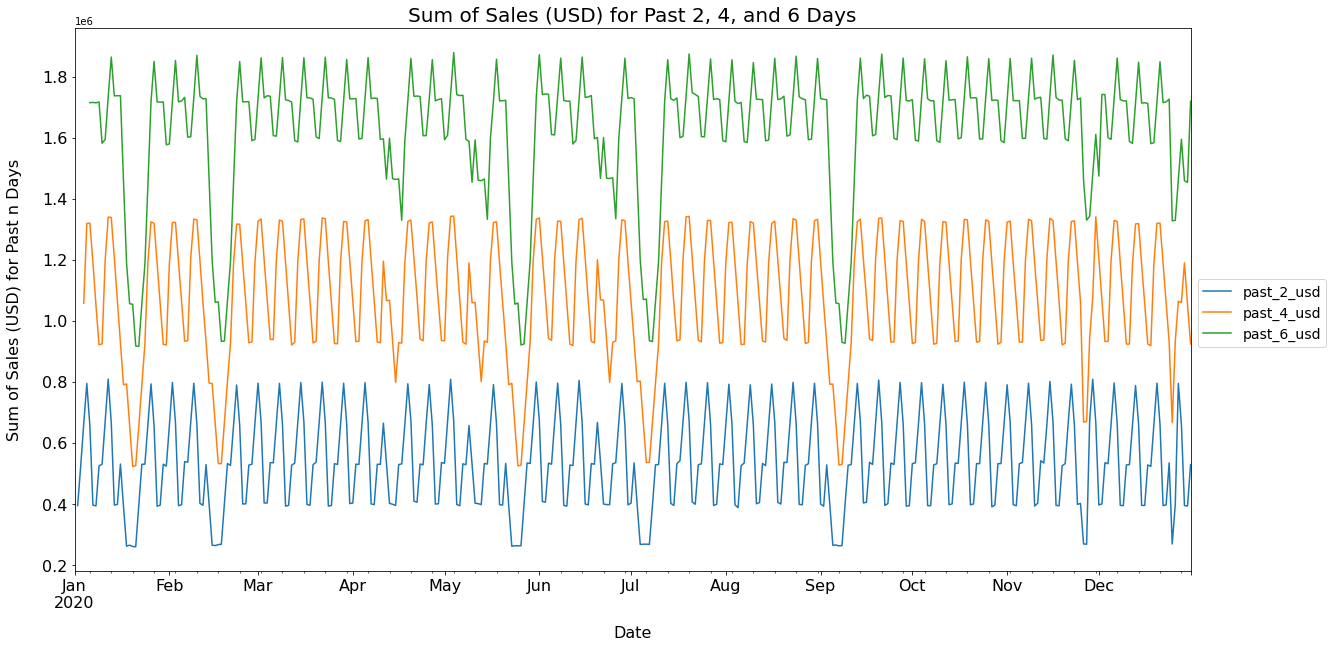